# ** Self-Driving Cars [Part 2 - ALVINN] **



[jupytertheme](https://github.com/dunovank/jupyter-themes) for presenting this talk: 

```
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
```

And viewing:
```
jt -t grade3 -cellw=90% -fs=14 -tfs=14 -ofs=14
```

- Originally, the ALV was intended to a "test bed" vehicle for universities. However, due to rigorous demo schedules and other factors, it was difficult for researchers to get time on the ALV.
- CMU requested $1.2M of DARPA funds to build two of thier own vehicles, and by early 1986 had purchased and outfitted a chevy van, and gave it the name Navlab (NAVigation LABratory)
- Max speed of 20 mph! (Suck it, ALV) Early demos ran at 10 centimeters per second.


![](../graphics/navlab.png)

- Many approaches were tried at CMU, let's talk about one particularly interesting approach taken by graduate student **Dean Pomerleau**
- To really get a feel for his approach, let's think about the problem we're trying to solve more broadly
- We're trying to **drive a car with a camera**, and here's a diagram of the approach we've tried so far:

![](../graphics/alv_pipeline-01.png)

- There are lots of ways we can break apart the driving problem into discrete blocks to engineer solutions, but broadly, if our car is going to steer (or fully drive itself), we must solve this problem:

![](../graphics/spacer_small-01.png)

![](../graphics/end-to-end-math-problem-01.png)

- If you want to drive a car with a camera, you must find an answer to this math problem
- One way to think about vision-based autonomous driving then is as a mapping from a very high dimensional space (one or more images), to a very low dimensional space (just steering angle, or in the case of lateral and longitudinal control, steering angle and speed)
- But, how do we go apart solving a math problem like this? We found one sub-optimal solution by studying the ALV, how else might we approach this problem?
- Here's a hint: when Dean Pomerleau showed up at CMU for graduate school in 1987, an associate professor name Geoff Hinton had just published a report entitled "Experiments on Learning by Back Propagation."
- This lead Pomerleau down an intersting path: 

# What if we used a neural network to learn, like, the whole thing?

![](../graphics/spacer_small-01.png)

- Is it possible to train a neural network to learn **all the math** to steer a car?
    - [FUN FACT] when I began working in autonomous driving in June 2016 I had exactly this conversation with a long-time friend and coworker, and I argued that this might not even be possible. Let's see if I was right...

# Can we teach a neural network to drive?

![](../videos/images_and_angle_wheego.gif)

- Or at least, to steer?
- Can we learn the mathematics of this (or one version of this) mapping?
- The forward direction of this problem makes reasonable sense, but to train a neural network, we must find an appoximate solution to the **inverse** problem!
    - Does steering wheel angle alone provide enough information to teach a learning algorithm how to interpret images of the road??

- Here's Pomerleau's original NIPS paper: **ALVINN: An Autonomous Land Vehicle In a Neural Network**

![](../graphics/pomerleau-nips.png)

![](../graphics/spacer_small-01.png)

- Here's the neural network architecture used by Dean Pomerleau
- Pomerleau (at least initially) just used the blue image channel, and downsampled his images to just (30x32) pixels.
- The output of ALVINN is setup cleverly - steering angles are grouped into 30 discrete bins, and training data is setups as a guasian distribution around the the bin corresponding to the current steering angle - this makes the problem more linear - small changes in input images correspond to small changes in output values.

![](../graphics/question-two-01.png)

![](../graphics/spacer_small-01.png)

In [1]:
30*32*4+30*4 #Plus bias units - but let's be honest, who really cares about counting those?

3960

- ~4k parameters
    - This is either a lot or like nothing depending on your perspective
    - Out last approach, the ALV VITS algorithm had 4 parameters
    - VGG-16, a modern popular deep neural network has 138M parameters!
- Now, if we're going to learning a mapping from images to steering wheel angles (that will hopefully drive a car!) we need some data.
    - One very cool thing about Pomerleau's idea here is that collecting data is easy!
    - Just put a camera and steering wheel angle sensor on a car, and record how a human drives!
        - This technique is called **behavioral cloning**, and it's an amazingly simple way to get lots and lots of data.

## **Data!**

- I've prepared a small dataset for us to play with
- Taken on a few test track laps


In [2]:
from jupyterthemes import jtplot
jtplot.style()

In [3]:
import h5py as h5
%pylab inline
data = h5.File('../data_sample/track_data_2.h5', 'r')

/Users/stephenwelch/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


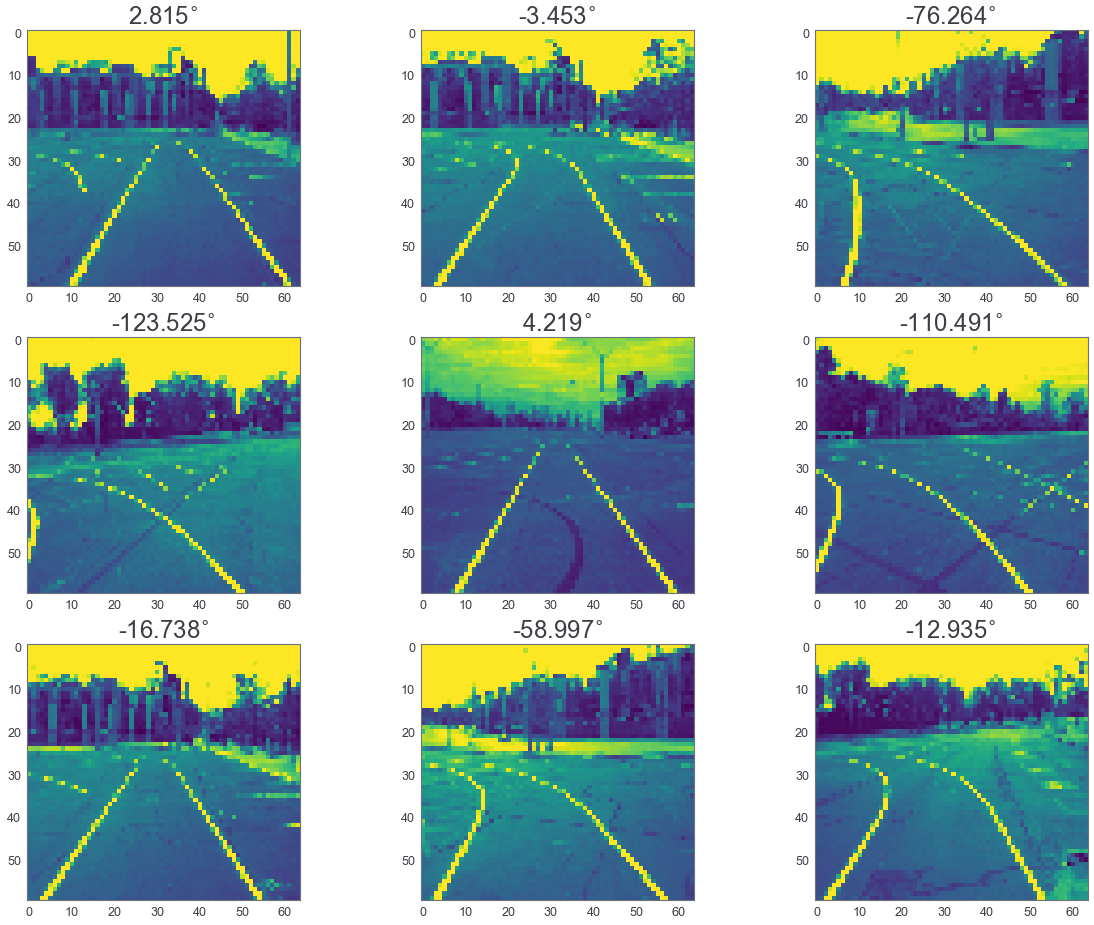

In [4]:
fig = figure(0, (20, 16))
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    imshow(data['images'][i*100, :, :]); grid(0)
    title(str(round(data['angles'][i*100], 3)) + '$^{\circ}$', fontsize = 24)

- Our data consists of the blue channels of resized images, and the corresponding steering angles.

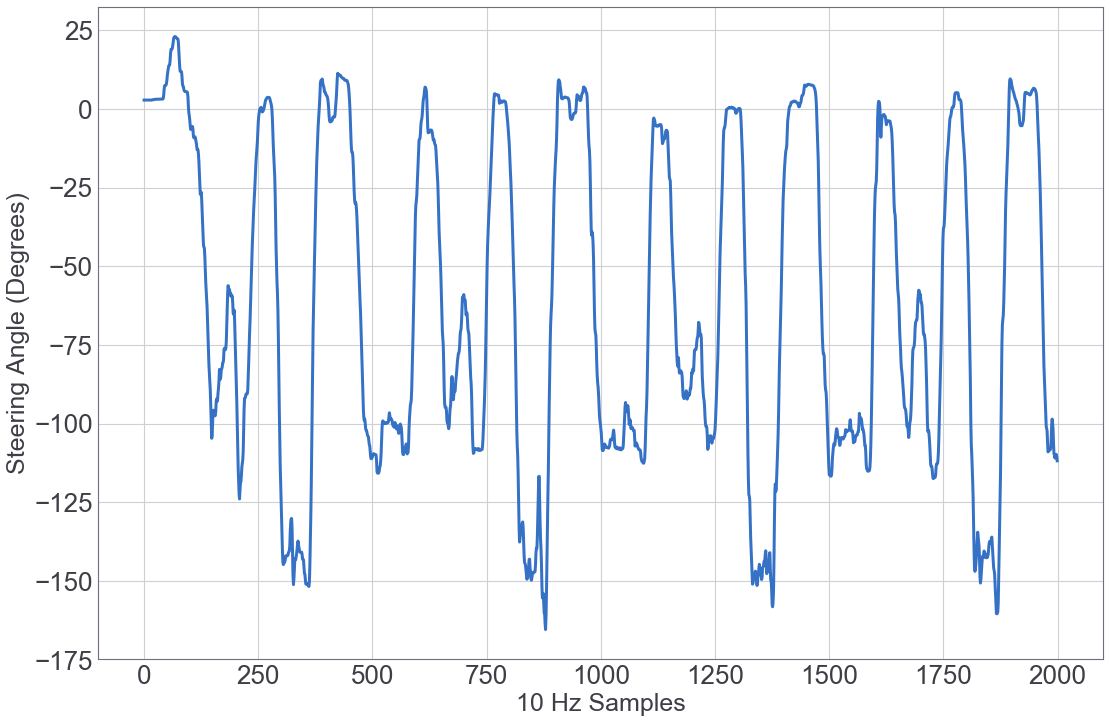

In [5]:
fig = figure(0, (18, 12))
plot(data['angles'], linewidth = 3)
ylabel('Steering Angle (Degrees)', fontsize = 25); xlabel('10 Hz Samples', fontsize = 25)
for tick in gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 

- Here's all the steering angles in our dataset sequentially. 
- Our data roughly has a periodicity of 3 - why?

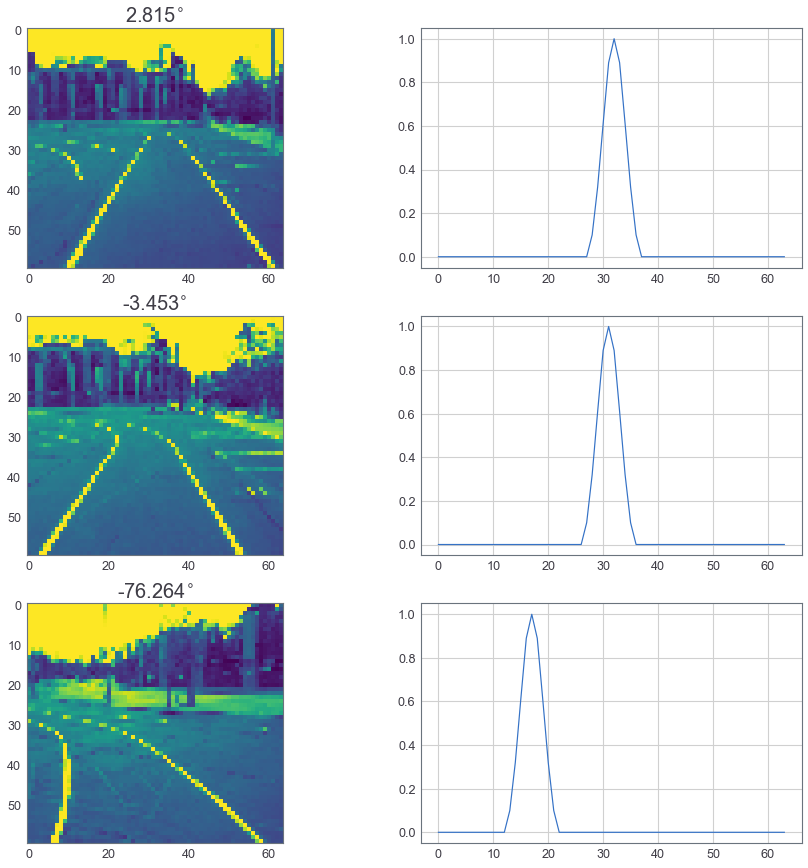

In [6]:
fig = figure(0, (15,15))
for i in range(3):
    fig.add_subplot(3,2,2*i+1)
    imshow(data['images'][i*100, :, :]); grid(0)
    title(str(round(data['angles'][i*100], 3)) + '$^{\circ}$', fontsize = 20)    
    
    fig.add_subplot(3,2,2*i+2)
    plot(data['encoded_angles'][i*100, :])

- Finally, I've also gone ahead and encoded our steering angles as pomerleau did.
- This really makes a big difference! 
    - Little tweaks and changes can make all the difference when optimizing the complex non-convex loss function we often find in neural networks. 
- Representing the correct steering angle as a distribution be make the difference between our network being able to learn or not!

### And finally, the most important part of any machine learning solution....
- Test train split!

In [7]:
training_indices = np.arange(1500)
testing_indices = np.arange(1500, 2000)

images_training = data['images'][training_indices, :, :]/255. #Normalize between 0 and 1
angles_training = data['encoded_angles'][training_indices, :]

images_testing = data['images'][testing_indices, :, :]/255. #Normalize between 0 and 1
angles_testing = data['encoded_angles'][testing_indices, :]

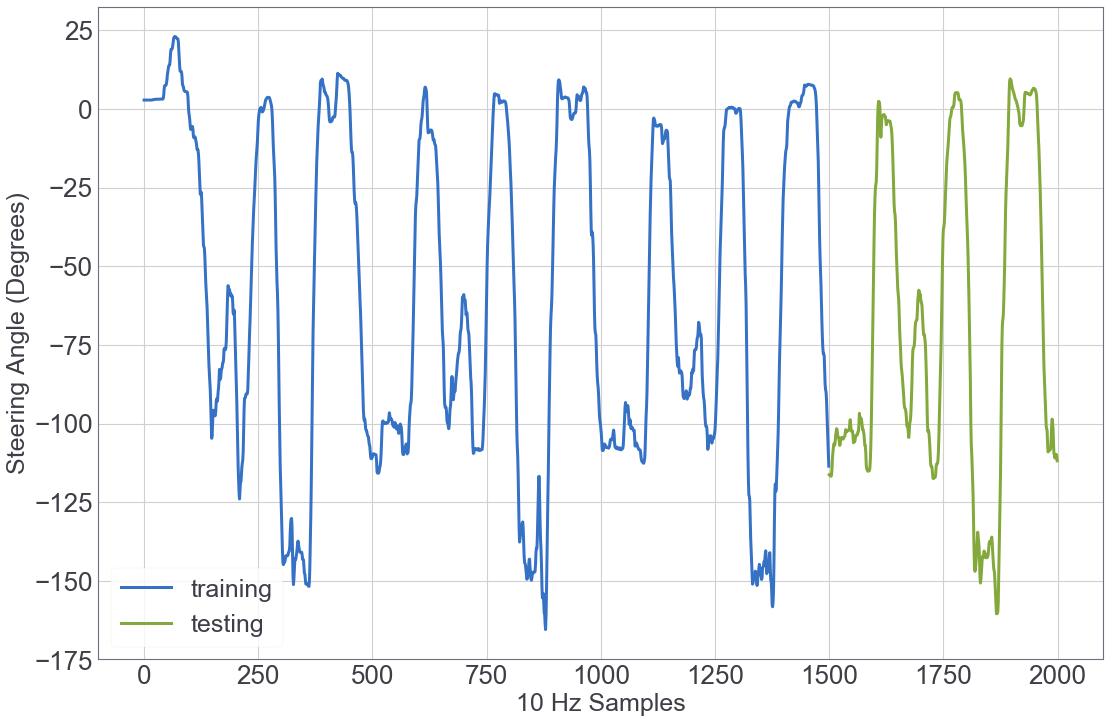

In [8]:
fig = figure(0, (18, 12))
plot(training_indices, data['angles'][:][training_indices], linewidth = 3)
plot(testing_indices, data['angles'][:][testing_indices], linewidth = 3)
ylabel('Steering Angle (Degrees)', fontsize = 25); xlabel('10 Hz Samples', fontsize = 25)
for tick in gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
legend(['training', 'testing'], fontsize = 25)

- We'll use ~3 laps (1500) images for training, and 1 lap (500) images for testing

# Ok, Let's build ALVINN in Tensorflow!

- Let me go ahead and start training, then we'll talk through the architecture

In [9]:
import tensorflow as tf

In [10]:
#Hyper Parameters
learning_rate = 1e-4
num_iterations = 5000

#How many bins is our data encoded into:
bins = angles_training.shape[1]

#Setup tf placeholders for images and angles
im = tf.placeholder(tf.float32, (None, 60, 64))
ang = tf.placeholder(tf.float32, (None, bins))

#Reshape input images into vectors
im_reshaped = tf.reshape(im, (-1, 60*64))

#Hidden Layer
a1 = tf.layers.dense(im_reshaped, 4, activation = tf.sigmoid)

#Output layer
yhat = tf.layers.dense(a1, bins)

#Loss function
loss = tf.losses.mean_squared_error(ang, yhat)

#Optimizer
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

- The fact that we can define the entire architecture of ALVINN in 5 lines of tensorflow is unreal.
- We'll make a few minor changes to the oringal network. 
    - 9 hidden units instead of 4
    - (64x60) images instead of (32x30)
    - 64 output bins instead of 32
    - That's it! Other than that this is the ALVINN network from the 1980s!

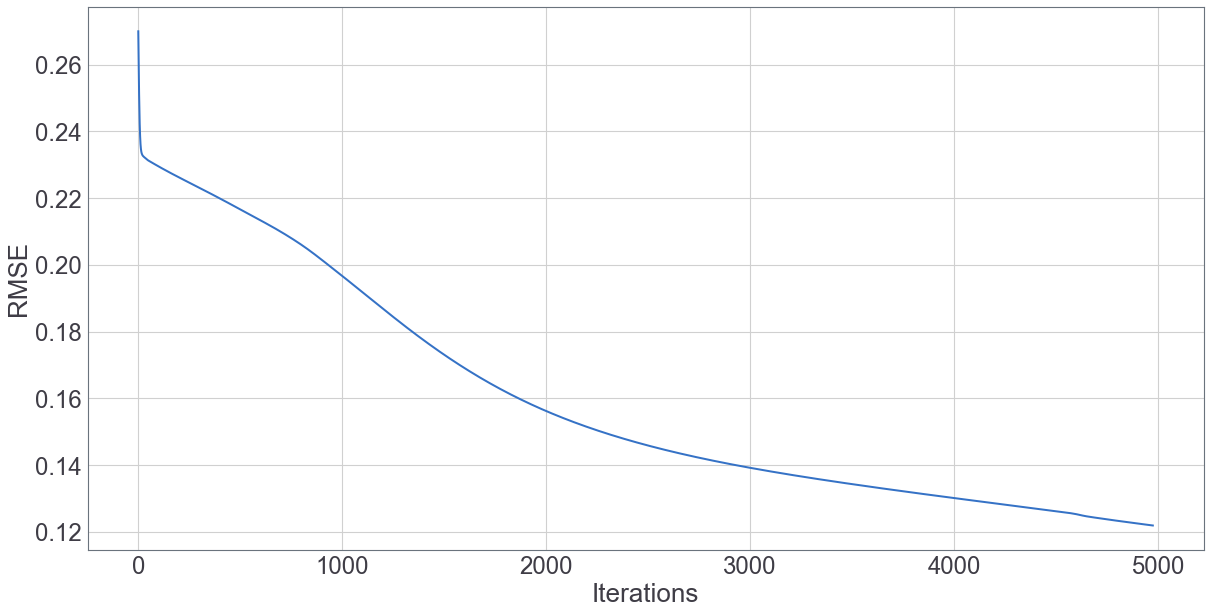

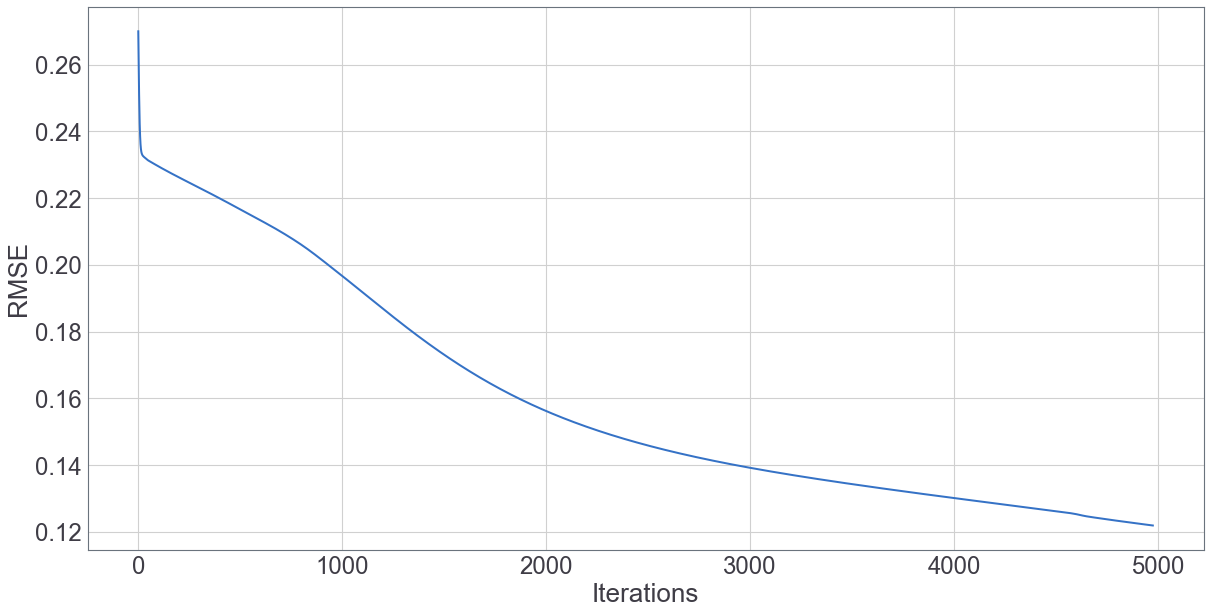

In [11]:
from IPython import display

#Store errors as we train in a list:
RMSEs = []

#Initialize Tensorflow session:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

#And train!
for i in range(num_iterations):
    #Train Step
    sess.run(train_op, feed_dict = {im:(images_training), ang:angles_training})
    #Measure error
    RMSEs.append(np.sqrt(loss.eval(feed_dict = {im:images_training, ang:angles_training})))

    #Visualize as we go!
    if i%25==0:
        clf(); fig = figure(0, (20, 10))
        ax = fig.add_subplot(111)
        plot(RMSEs, linewidth = 2)
        xlabel('Iterations', fontsize = 26); ylabel('RMSE', fontsize = 26)
        ax.xaxis.set_tick_params(labelsize=24)
        ax.yaxis.set_tick_params(labelsize=24)
        display.clear_output(wait=True); display.display(gcf())

In [12]:
#Network Predictions on Testing Images:
yhat_array = yhat.eval(feed_dict = {im:images_testing})

#Center values of our prediction bins:
centers = np.linspace(-165, 165, bins)

# Convert probabilistic prediction to a single angle
predicted_angles = []
for i in range(yhat_array.shape[0]):
    #Just pick bin with largest value:
    predicted_angles.append(centers[argmax(yhat_array[i, :])])
    
    #Fancy weighted average:
    #predicted_angles.append(sum(centers[yhat_array[i, :] > 0.3]*yhat_array[i, \
    #                    yhat_array[i, :] > 0.3])/sum(yhat_array[i, yhat_array[i, :] > 0.3]))

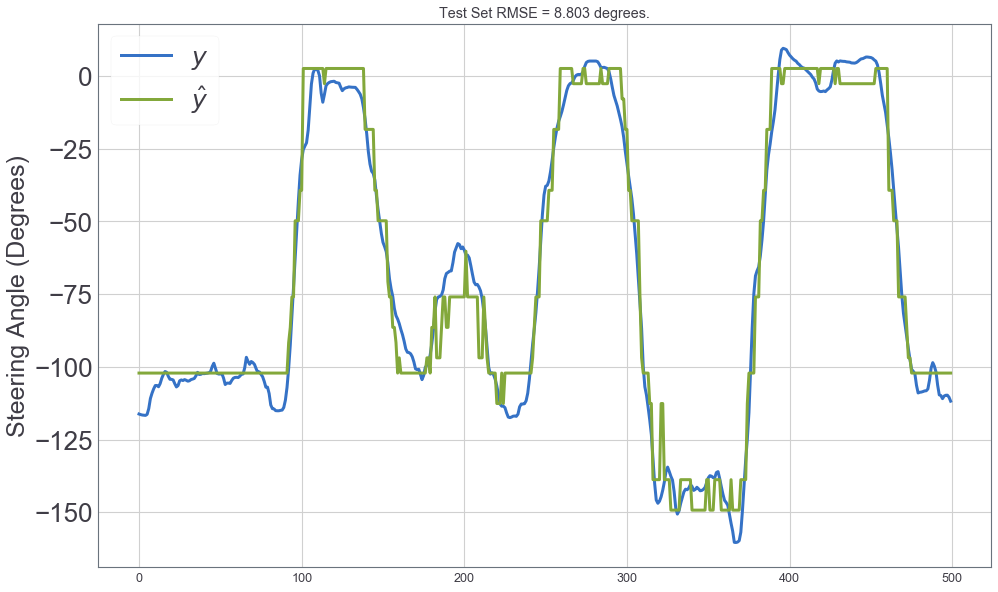

In [13]:
fig = figure(0, (16, 10))
plot(data['angles'][:][testing_indices], linewidth = 3)
plot(predicted_angles, linewidth = 3)
ylabel('Steering Angle (Degrees)', fontsize = 25);
title('Test Set RMSE = ' + str(round(np.sqrt(np.mean((predicted_angles- data['angles'][:][testing_indices])**2)), 3)) + ' degrees.')
legend(['$y$', '$\hat{y}$'], fontsize = 25)
for tick in gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 

## Our ALVINN learned!
- From 3 laps of test track driving data, ALVINN learned to predict quite close to the correct steering angle on our 4th lap!
- Just using camera images and our human steering angle, ALVINN learned to drive (somewhat) like a human!
- Pretty cool, right?!
- I think it's soo remarkable that the (relatively sparse) information source of just the steering angle is enough to teach our network to pick out salient image features!
- Let's explore this a little more deeply.

# Now, what the heck did our network learn to "see"?

- What mathematical mapping from images to steering angle did our algorithm learn?
- Let's have a closer look at ALVINN's parameters during training.

![](../videos/training_animation_smaller.gif)

### <center> *"...in this paradigm the data, not the programmer, determines the salient image features crucial to accurate road navigation" * </center>

<div style="text-align: right">- Dean Pomerleau in ALVINN: An Autonomous Land Vehicle in a Neural Network </div>

- Our network has learned to interpret driving images based ONLY on steering angle! 
- For this data (track data with only left turns), our network has learned a set of lane marker detectors!


## **ALVINN Domination**

- For a number of years from the late 1980s to the early 1990s, ALVINN was the most successfull vision algorithm for autonomous driving at CMU, and possibly on the planet.
- Faster computers enabled faster driving, and more sophisticated training and data augmentation procedures allowed ALVINN to learn quickly and effectively across many environments.

![](../videos/NAVLAB_B.gif)

- And quite recently, Nvidia implemented Pomerleau's idea using **Deep Neural Networks**
- Great writeup in their publication [End to end learning for self-driving cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)
- Pomerleau orinally trained on ~5 minutes of driving, Nvidia trained on 3000 hours
    - That's 36,000 times the amount of data - **5 orders of magnitude** increase in dataset size in 30 years. 


![](papers/nvidia.png)

Here's the Architecture Nvidia used:

![](../graphics/nvidia-architecture-01.png)

- ~125k parameters
- So we've gone from 4 parameters in the ALV algorithm to 4k parameters in ALVINN to 125k pameters in Nvidia's end-to-end deep learning algorithm!
- And here's Nvidia's network driving in lots of different environments:

![](../videos/Nvidia_short.gif)

# Ok, so time for production, right?

- Here's where it gets interesting. Many folks in the Autonomous Driving industry do not believe we will ever see an end-to-end systems in production. 
- And further, we didn't quite finish our story from earlier, about the 98% autonomous "No Hand Across America" Navlab 5 journey in 1995 - intrestingly Pomerleau didn't use ALVINN!
    

# So, **why not?** 
- Why do you think end-to-end systems like ALVINN may not be part of future autonomous cars?
- What are the potential weaknesses of this approach? Thoughts?

![](graphics/spacer_small-01.png)

## References

[1] Roland, Alex; Shiman, Philip (2002). Strategic Computing: DARPA and the Quest for Machine Intelligence, 1983-1993. Cambridge, Mass.: MIT Press. ISBN 0-262-18226-2.

[2] "Look Ma, No Driver" Jim Schefter. Popular Science, October 1985. 

[3] [VITS - A Vision System for Autonomous Land Vehicle Navigation](http://www.cs.ucsb.edu/~mturk/Papers/ALV.pdf); Matthew Turk, David Morgenthaler, Keight Gremban, and Martin Marra